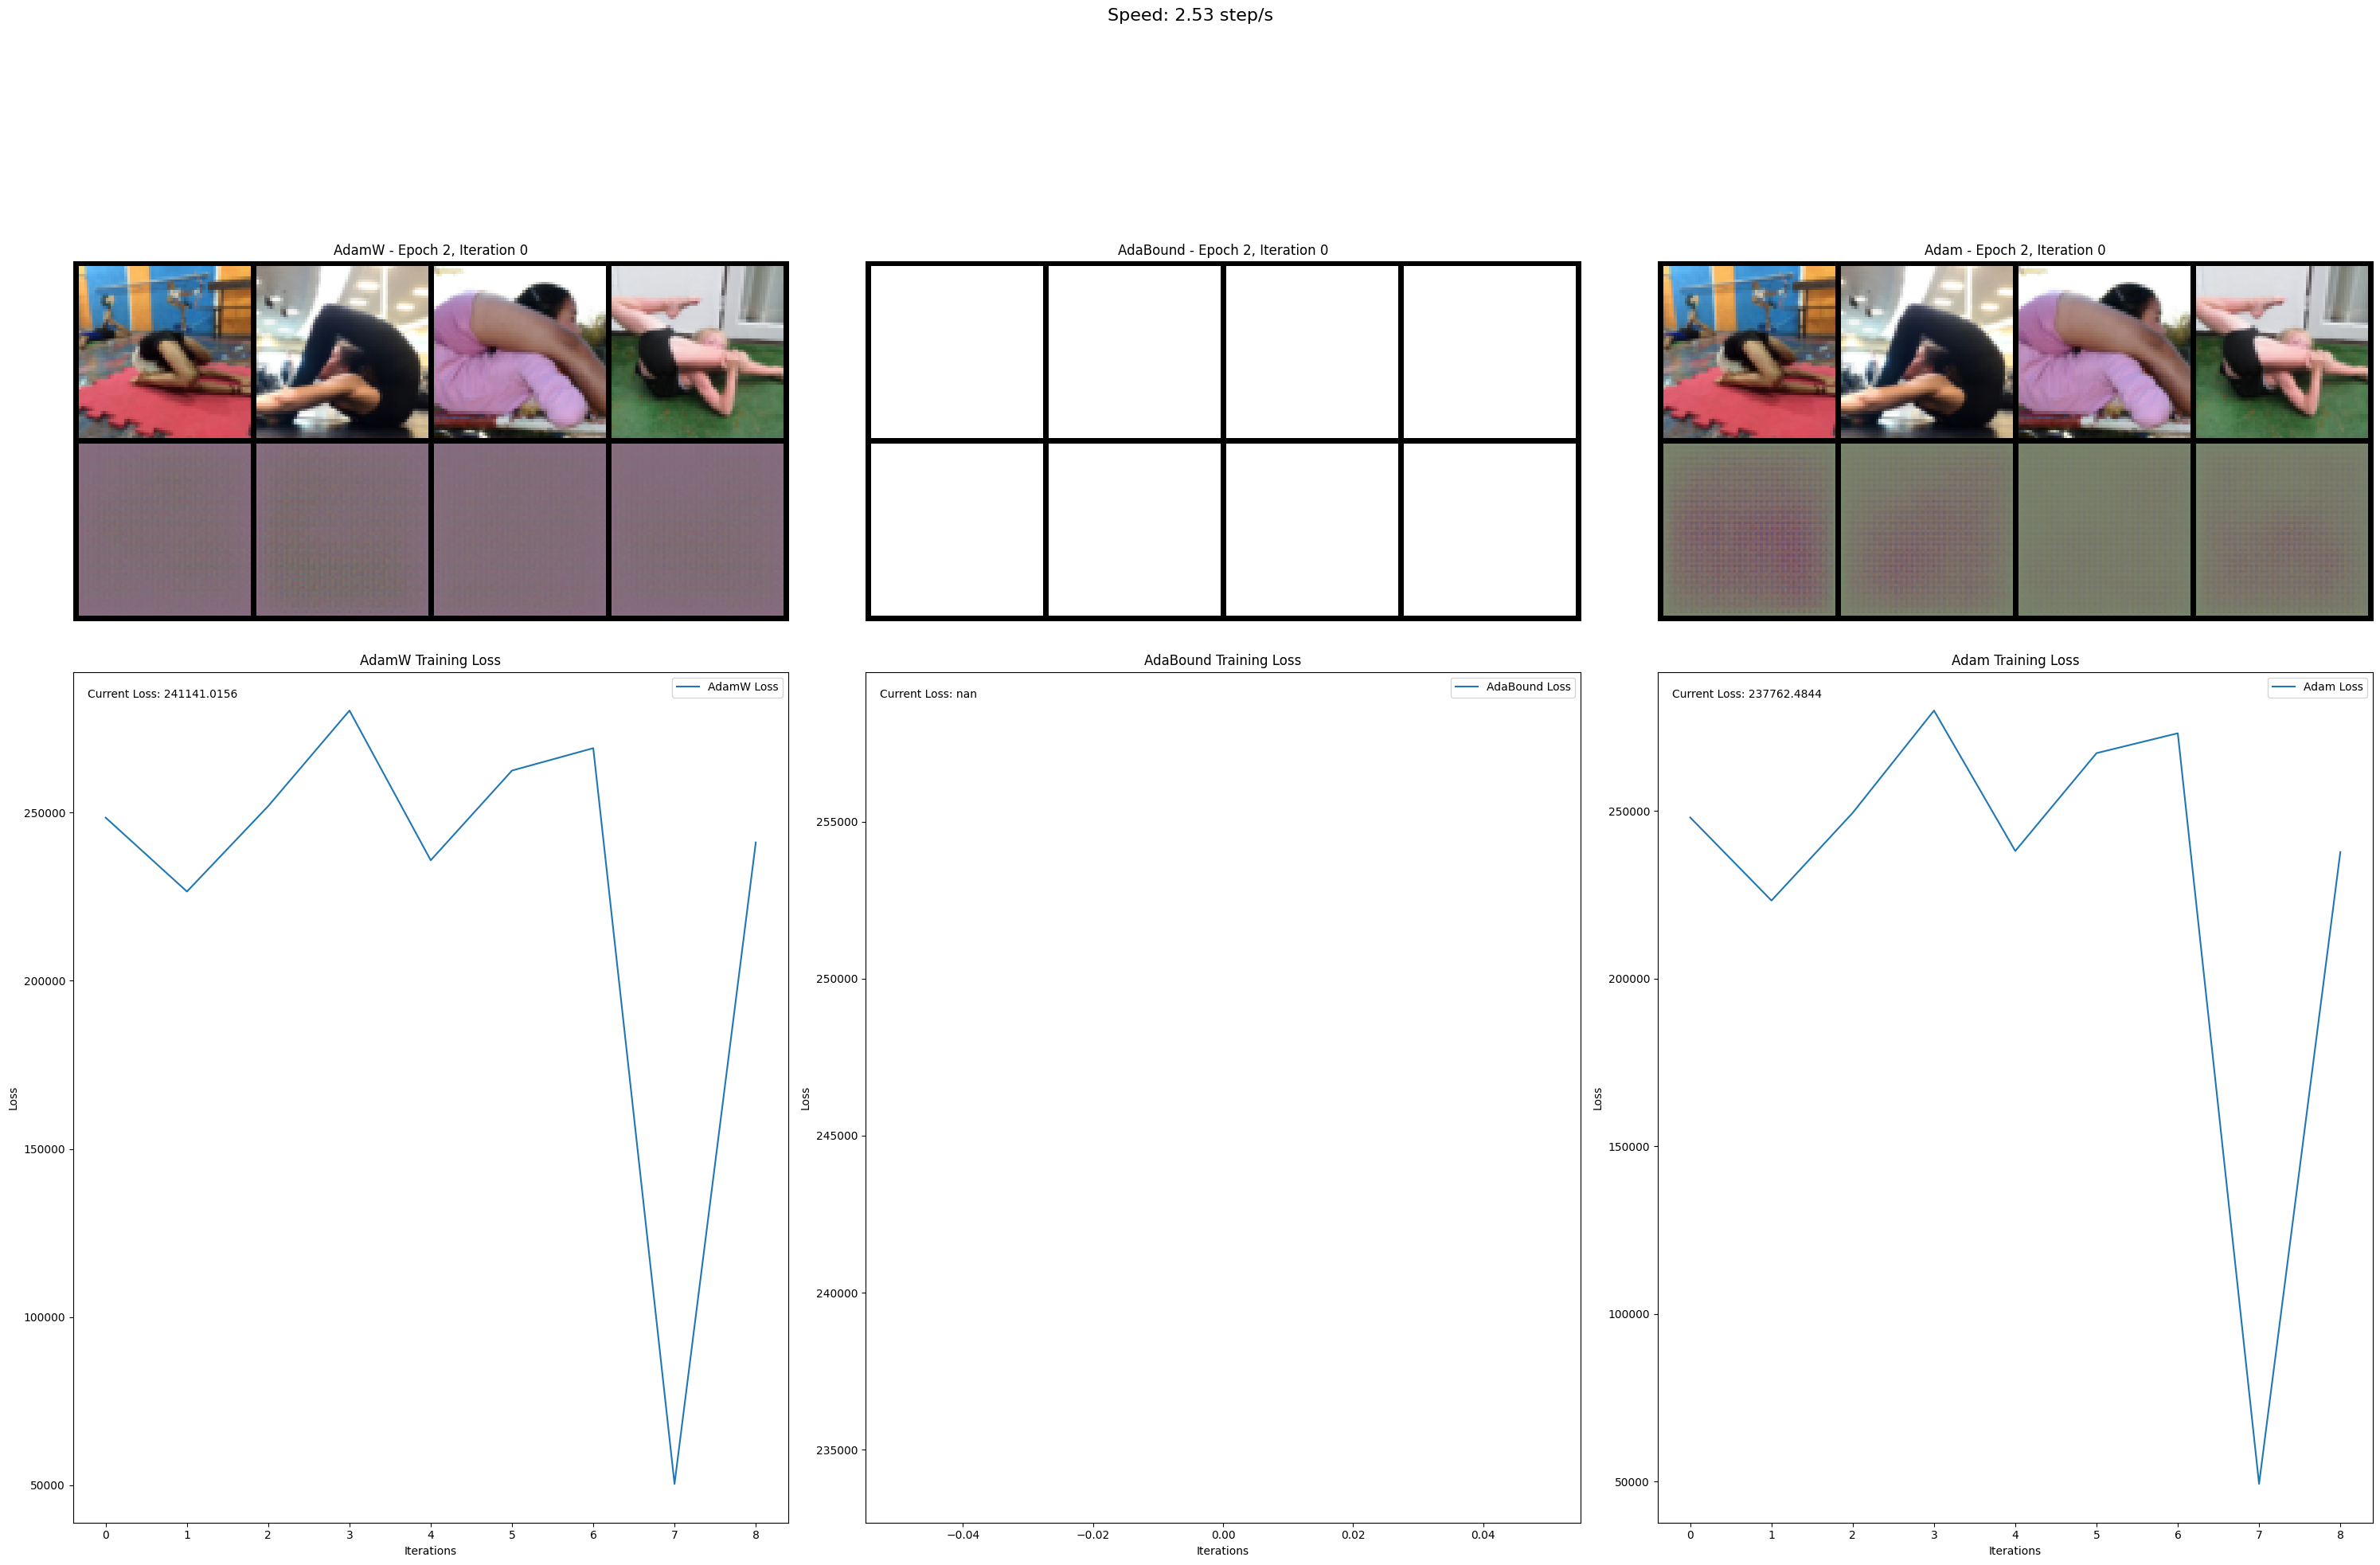

 25%|██▌       | 2/8 [00:01<00:04,  1.35it/s]


KeyboardInterrupt: 

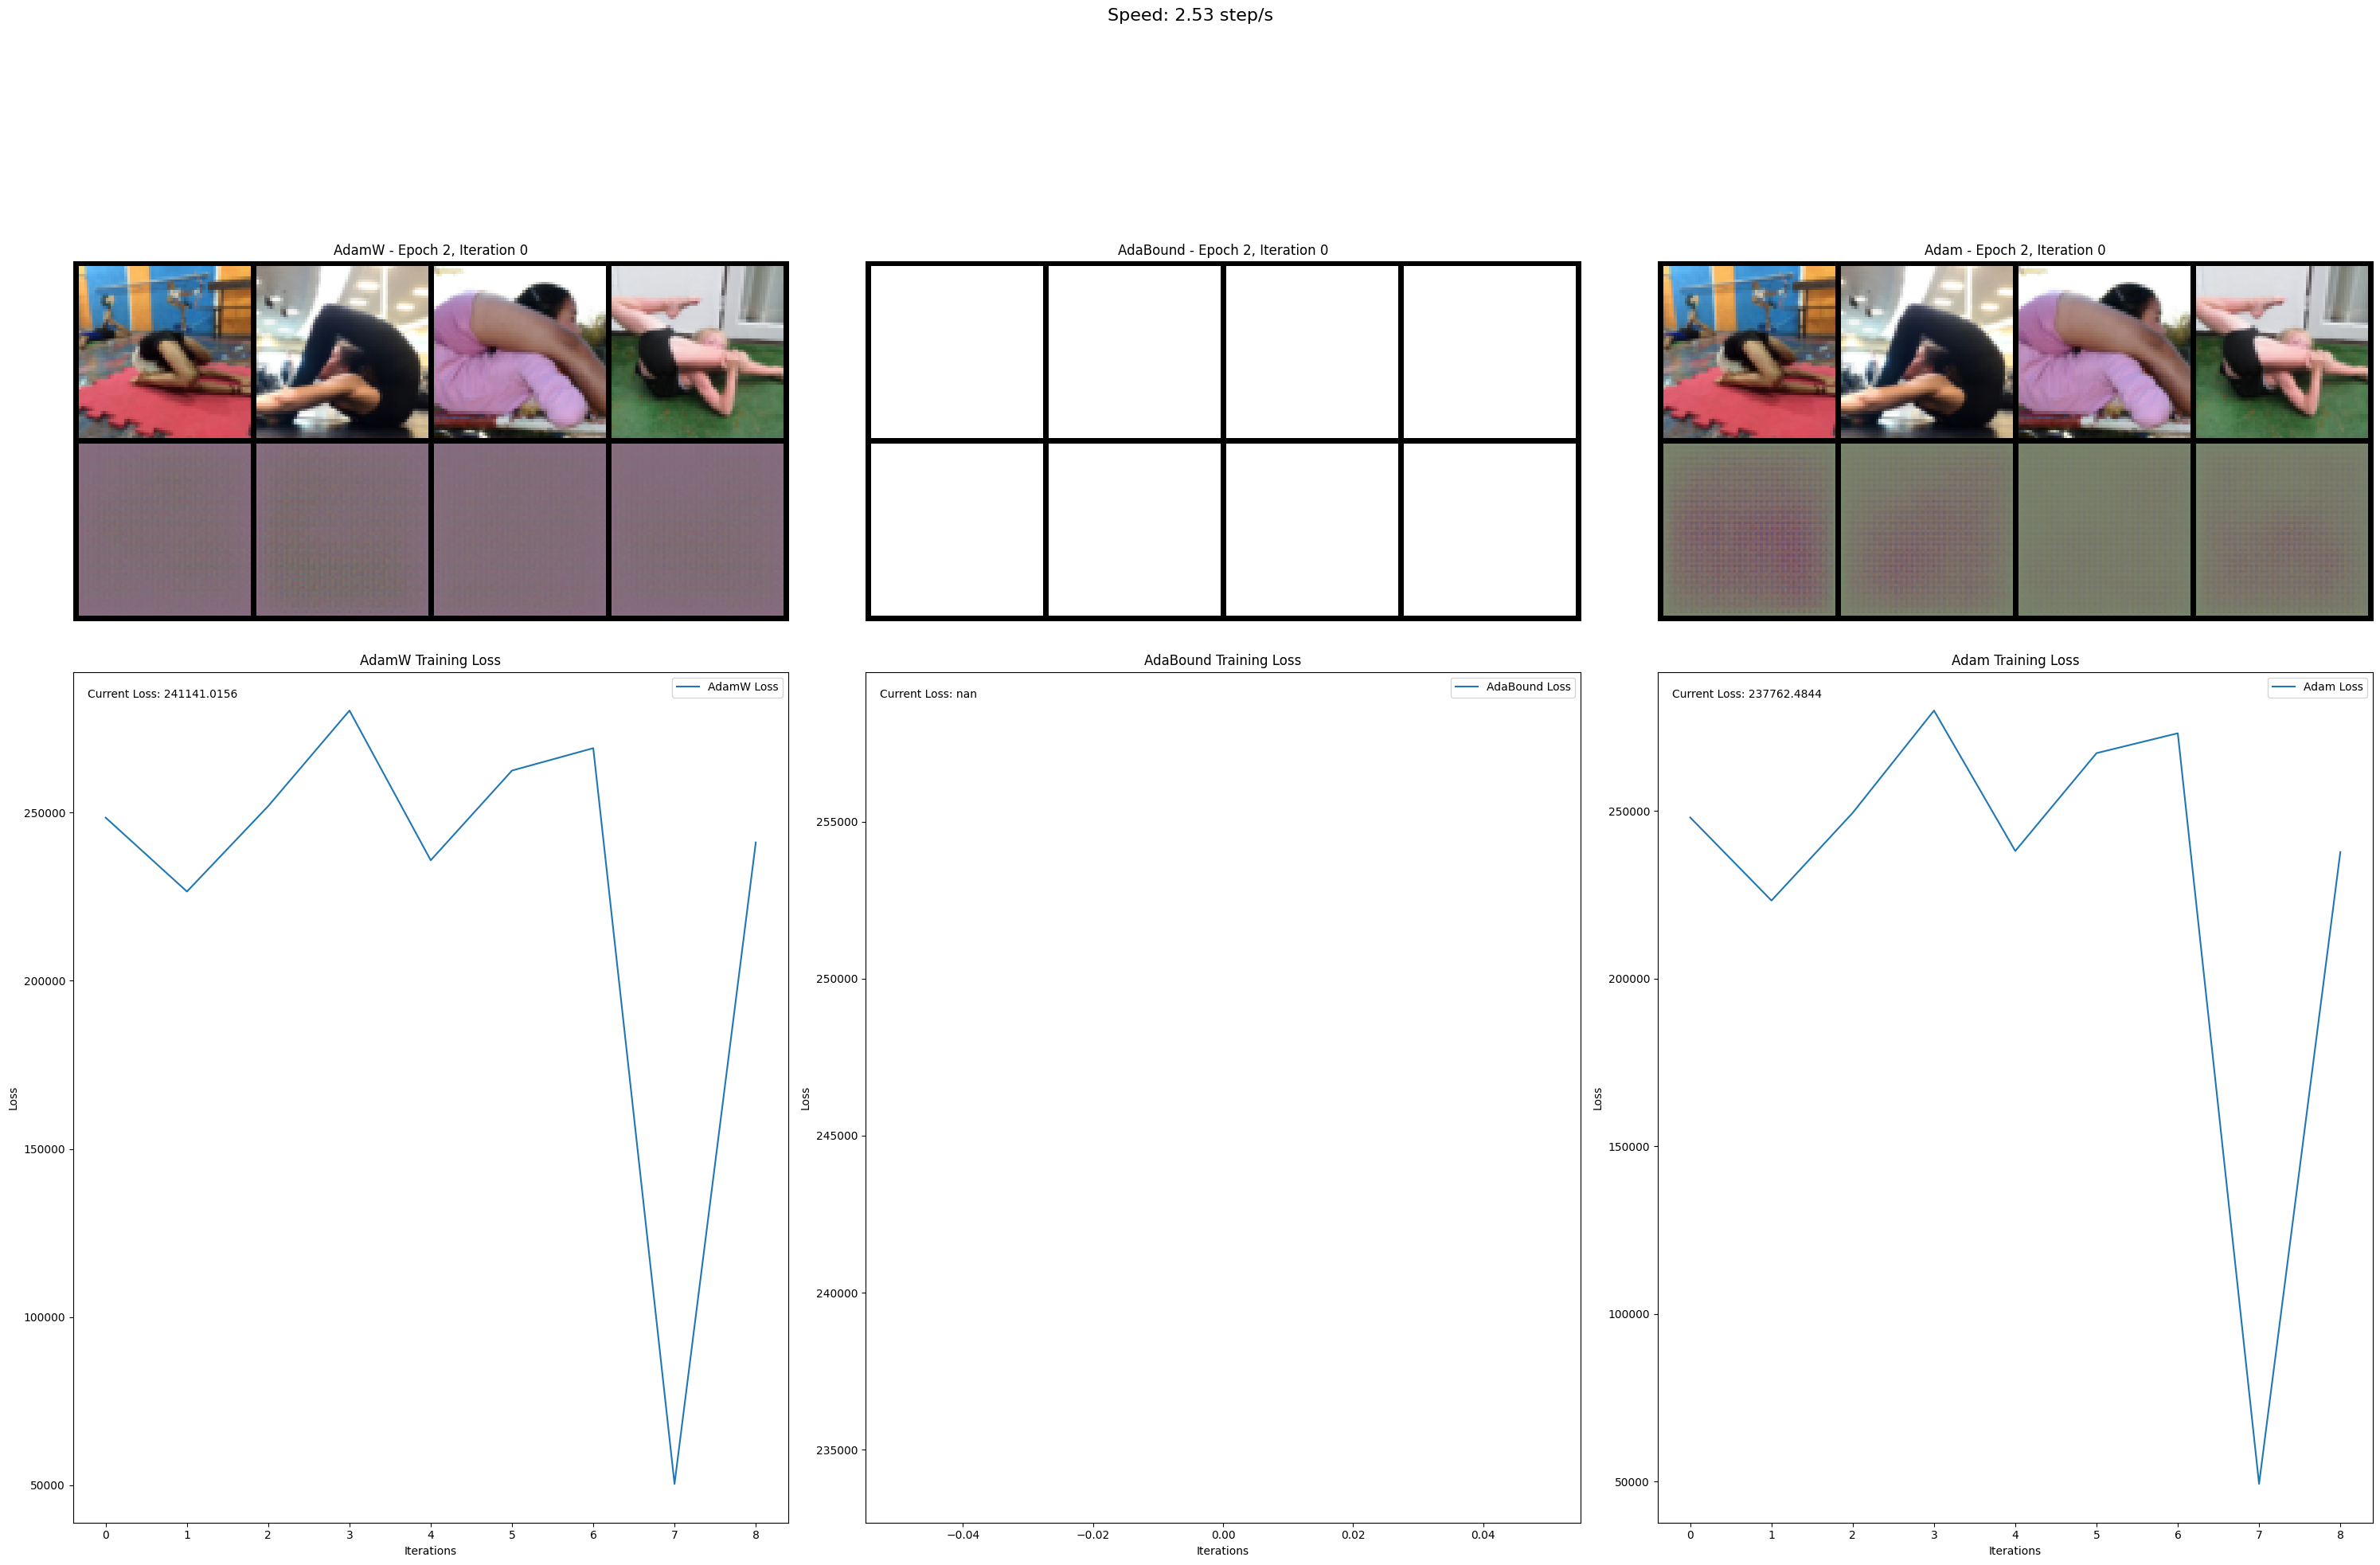

In [1]:
import time

import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

import torch
import torch.nn as nn
from pyrodigy.optimizer_wrapper import OptimizerWrapper
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)

# Define hyperparameters
latent_dim = 100
img_size = 64
channels = 3
batch_size = 64
epochs = 200
lr = 0.0002
beta1 = 0.5

# Set up data loading
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root='D:\\Diffusion\\Training\\_datasets\\dreamweaver\\dreamweaver_cont\\backbend-chest-side', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 4 * 4)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, channels, 4, 2, 1),
            nn.Tanh()
        )
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.decoder_input(z)
        h = h.view(-1, 256, 4, 4)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Initialize models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_adamw = VAE().to(device)
vae_adabound = VAE().to(device)
vae_adam = VAE().to(device)

optimizer_adamw = AdamW(vae_adamw.parameters(), lr=0.001, weight_decay=0.01)
optimizer_adabound = OptimizerWrapper(vae_adabound.parameters(), "a2grad", "high_memory")
optimizer_adam = Adam(vae_adam.parameters(), lr=0.001)

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training loop
losses_adamw = []
losses_adabound = []
losses_adam = []

# Set up the plot
plt.ion()
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30, 20))
fig.show()

# Initialize variables for speed calculation
start_time = time.time()
steps = 0
speed = 0

for epoch in range(epochs):
    for i, (images, _) in enumerate(tqdm(dataloader)):
        images = images.to(device)
        
        # AdamW
        recon_images_adamw, mu_adamw, logvar_adamw = vae_adamw(images)
        loss_adamw = loss_function(recon_images_adamw, images, mu_adamw, logvar_adamw)
        optimizer_adamw.zero_grad()
        loss_adamw.backward()
        optimizer_adamw.step()
        losses_adamw.append(loss_adamw.item())
        
        # AdaBound
        recon_images_adabound, mu_adabound, logvar_adabound = vae_adabound(images)
        loss_adabound = loss_function(recon_images_adabound, images, mu_adabound, logvar_adabound)
        optimizer_adabound.zero_grad()
        loss_adabound.backward()
        optimizer_adabound.step()
        losses_adabound.append(loss_adabound.item())
        
        # Adam
        recon_images_adam, mu_adam, logvar_adam = vae_adam(images)
        loss_adam = loss_function(recon_images_adam, images, mu_adam, logvar_adam)
        optimizer_adam.zero_grad()
        loss_adam.backward()
        optimizer_adam.step()
        losses_adam.append(loss_adam.item())
        
        # Calculate speed
        steps += 1
        elapsed_time = time.time() - start_time
        speed = steps / elapsed_time
        
        # Visualize results every 50 iterations
        if i % 50 == 0:
            with torch.no_grad():
                # AdamW
                recon_images_adamw = vae_adamw(images)[0].cpu()
                comparison_adamw = torch.cat([images[:4].cpu(), recon_images_adamw[:4]])
                grid_adamw = make_grid(comparison_adamw, nrow=4, normalize=True)
                
                # AdaBound
                recon_images_adabound = vae_adabound(images)[0].cpu()
                comparison_adabound = torch.cat([images[:4].cpu(), recon_images_adabound[:4]])
                grid_adabound = make_grid(comparison_adabound, nrow=4, normalize=True)
                
                # Adam
                recon_images_adam = vae_adam(images)[0].cpu()
                comparison_adam = torch.cat([images[:4].cpu(), recon_images_adam[:4]])
                grid_adam = make_grid(comparison_adam, nrow=4, normalize=True)
                
                # Plot reconstructions
                ax1.clear()
                ax1.imshow(grid_adamw.permute(1, 2, 0))
                ax1.axis('off')
                ax1.set_title(f"AdamW - Epoch {epoch+1}, Iteration {i}")
                
                ax2.clear()
                ax2.imshow(grid_adabound.permute(1, 2, 0))
                ax2.axis('off')
                ax2.set_title(f"AdaBound - Epoch {epoch+1}, Iteration {i}")
                
                ax3.clear()
                ax3.imshow(grid_adam.permute(1, 2, 0))
                ax3.axis('off')
                ax3.set_title(f"Adam - Epoch {epoch+1}, Iteration {i}")
                
                # Plot loss curves
                ax4.clear()
                ax4.plot(losses_adamw, label='AdamW Loss')
                ax4.set_xlabel('Iterations')
                ax4.set_ylabel('Loss')
                ax4.legend()
                ax4.set_title('AdamW Training Loss')
                
                ax5.clear()
                ax5.plot(losses_adabound, label='AdaBound Loss')
                ax5.set_xlabel('Iterations')
                ax5.set_ylabel('Loss')
                ax5.legend()
                ax5.set_title('AdaBound Training Loss')
                
                ax6.clear()
                ax6.plot(losses_adam, label='Adam Loss')
                ax6.set_xlabel('Iterations')
                ax6.set_ylabel('Loss')
                ax6.legend()
                ax6.set_title('Adam Training Loss')
                
                # Add current loss values and speed to the plot
                fig.suptitle(f"Speed: {speed:.2f} step/s", fontsize=16)
                ax4.text(0.02, 0.98, f"Current Loss: {loss_adamw.item():.4f}", transform=ax4.transAxes, verticalalignment='top')
                ax5.text(0.02, 0.98, f"Current Loss: {loss_adabound.item():.4f}", transform=ax5.transAxes, verticalalignment='top')
                ax6.text(0.02, 0.98, f"Current Loss: {loss_adam.item():.4f}", transform=ax6.transAxes, verticalalignment='top')
                
                plt.tight_layout()
                
                # Update the plot
                fig.canvas.draw()
                fig.canvas.flush_events()
                
                # Display the plot (for Jupyter notebook)
                clear_output(wait=True)
                display(fig)
    
    print(f"Epoch [{epoch+1}/{epochs}], AdamW Loss: {loss_adamw.item():.4f}, AdaBound Loss: {loss_adabound.item():.4f}, Adam Loss: {loss_adam.item():.4f}")

plt.ioff()
plt.show()